In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random, json, time, datetime, os, torch, nltk
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AutoTokenizer, BloomForCausalLM
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

nltk.download('punkt')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
model_name = 'gpt2'
# model_name = 'flax-community/gpt2-small-indonesian'
# model_name = 'akahana/gpt2-indonesia'
# model_name = 'cahya/gpt2-small-indonesian-522M' 
epochs = 100
batch_size = 8
max_length = 100
warmup_steps = 1e2
sample_every = 100
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
output_dir = "/kaggle/working/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def load_model_tokenizer(model_name_or_dir, ablated_component=None):
    bos_token,eos_token,pad_token='<|startoftext|>','<|endoftext|>','<|pad|>'
    # Load from Hugging Face's model hub if it's a name
    tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_dir,
                                              bos_token=bos_token,
                                              eos_token=eos_token,
                                              pad_token=pad_token)
    config = GPT2Config.from_pretrained(model_name_or_dir)
    if ablated_component == 'attention_heads':
        # Ablate attention heads
        config.num_attention_heads = 2
#         config.hidden_size = 1280
#         config.embed_dim = 1280
    elif ablated_component == 'layers':
        # Ablate layers
        config.num_hidden_layers = 4
    model = GPT2LMHeadModel.from_pretrained(model_name_or_dir, config=config)
    model.resize_token_embeddings(len(tokenizer))

    # Move model to GPU if available
    model = model.to(device)

    return model, tokenizer

In [4]:
model, tokenizer = load_model_tokenizer(model_name,'layers')
tokenizer.pad_token = tokenizer.eos_token
print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')
print(model)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2LMHeadModel: ['h.10.attn.bias', 'h.10.attn.c_attn.bias', 'h.10.attn.c_attn.weight', 'h.10.attn.c_proj.bias', 'h.10.attn.c_proj.weight', 'h.10.ln_1.bias', 'h.10.ln_1.weight', 'h.10.ln_2.bias', 'h.10.ln_2.weight', 'h.10.mlp.c_fc.bias', 'h.10.mlp.c_fc.weight', 'h.10.mlp.c_proj.bias', 'h.10.mlp.c_proj.weight', 'h.11.attn.bias', 'h.11.attn.c_attn.bias', 'h.11.attn.c_attn.weight', 'h.11.attn.c_proj.bias', 'h.11.attn.c_proj.weight', 'h.11.ln_1.bias', 'h.11.ln_1.weight', 'h.11.ln_2.bias', 'h.11.ln_2.weight', 'h.11.mlp.c_fc.bias', 'h.11.mlp.c_fc.weight', 'h.11.mlp.c_proj.bias', 'h.11.mlp.c_proj.weight', 'h.4.attn.bias', 'h.4.attn.c_attn.bias', 'h.4.attn.c_attn.weight', 'h.4.attn.c_proj.bias', 'h.4.attn.c_proj.weight', 'h.4.ln_1.bias', 'h.4.ln_1.weight', 'h.4.ln_2.bias', 'h.4.ln_2.weight', 'h.4.mlp.c_fc.bias', 'h.4.mlp.c_fc.weight', 'h.4.mlp.c_proj.bias', 'h.4.mlp.c_proj.weight', 'h.5.attn.bias', 'h.5.attn.c_attn.bi

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

67.738368 M parameters
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)


In [5]:
# # model = GemmaModel.from_pretrained("hf-internal-testing/dummy-gemma")
# # tokenizer = GemmaTokenizerFast.from_pretrained("hf-internal-testing/dummy-gemma")
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
# model = BloomForCausalLM.from_pretrained("bigscience/bloom-560m")
# # tokenizer.pad_token = tokenizer.eos_token
# print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

In [6]:
df = pd.read_csv('/kaggle/input/dataset-pantun-indonesia/dataset-pantun.csv')
df = df[['teks','tipe']]
df

,teks,tipe
0,Ada motor ada sepeda \n Semuanya beroda dua \n Indonesia kaya budaya \n Sepatutnya kita menjaganya,Pantun Adat dan Alam
1,Ada pisang ada semangka \n Jika dimakan manis rasanya \n Indonesia ragam budaya \n Tugas kita tuk menjaganya,Pantun Adat dan Alam
2,Ada rusa ada buaya \n Sungguh hitam warna matanya \n Ada adat seribu bahasa \n Kita wajib menghormatinya,Pantun Adat dan Alam
3,Alat timbang pucuknya patah \n Beli baru hendak dipesan \n Alam terkembang amat indah \n Dipandang-pandang tiada bosan,Pantun Adat dan Alam
4,Anak cina makan petai \n Kakinya terikat rantai \n Lihatlah indahnya pantai \n Membuat jiwa terasa santai,Pantun Adat dan Alam
...,...,...
1445,Jalan-jalan ke surabaya \n Pulangnya beli hadiah \n Jika ingin cepat kaya \n Tidak susah tinggal sedekah,NaN
1446,Hari malam gelap-gelita \n Pasang lilin jalan ke taman \n Sopan santun budaya kita \n Jadi kebanggaan zaman berzaman,NaN
1447,Apa guna berkain batik \n Kalau tidak dengan sucinya? \n Apa guna beristeri cantik \n Kalau tidak dengan budinya,NaN
1448,Buah cempedak di luar pagar \n Ambil galah tolong jolokkan \n Saya budak baru belajar \n Kalau salah tolong tunjukkan,NaN


In [7]:
print(df[df['teks'].str.contains("Di kamar tidur teronggok cermin")]['teks'])

452    Di kamar tidur teronggok cermin \n Cermin dipakai untuk berdandan \n Di tanah lapang kami bermain \n Bermain gundu juga layangan
Name: teks, dtype: object


In [8]:
# Convert data to list of dictionaries
formatted_data = []
for idx, row in df.iterrows():
    formatted_data.append({'id': idx, 'poem': row['teks']})

formatted_data[0:5]

[{'id': 0,
  'poem': 'Ada motor ada sepeda \\n Semuanya beroda dua \\n Indonesia kaya budaya \\n Sepatutnya kita menjaganya'},
 {'id': 1,
  'poem': 'Ada pisang ada semangka \\n Jika dimakan manis rasanya \\n Indonesia ragam budaya \\n Tugas kita tuk menjaganya'},
 {'id': 2,
  'poem': 'Ada rusa ada buaya \\n Sungguh hitam warna matanya \\n Ada adat seribu bahasa \\n Kita wajib menghormatinya'},
 {'id': 3,
  'poem': 'Alat timbang pucuknya patah \\n Beli baru hendak dipesan \\n Alam terkembang amat indah \\n Dipandang-pandang tiada bosan'},
 {'id': 4,
  'poem': 'Anak cina makan petai \\n Kakinya terikat rantai \\n Lihatlah indahnya pantai \\n Membuat jiwa terasa santai'}]

In [9]:
data = formatted_data

In [10]:
class PoemDataset(Dataset):
    def __init__(self, poems, tokenizer, max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for poem in poems:

            encodings_dict = tokenizer("<|startoftext|>"+poem["poem"]+"<|endoftext|>",
                                     truncation=True,
                                     max_length=max_length,
                                     padding="max_length")
#             encodings_dict = tokenizer(poem["poem"],
#                                      truncation=True,
#                                      max_length=max_length,
#                                      padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
            self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [11]:
print(tokenizer.encode("Hello World", padding="max_length", max_length=10))
print(len(tokenizer))

[15496, 2159, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
50259


In [12]:
print(tokenizer.encode("<|startoftext|> Hello World <|endoftext|>", padding="max_length", max_length=10))
print(len(tokenizer))

[50257, 18435, 2159, 220, 50256, 50256, 50256, 50256, 50256, 50256]
50259


In [13]:
# Finding length of maximum token in dataset
max_length = max([len(tokenizer.encode(poem["poem"])) for poem in data])
print(max_length)
max_length = 100

82


In [14]:
x = [len(tokenizer.encode(poem["poem"])) for poem in data if len(tokenizer.encode(poem["poem"])) < 100]

In [15]:
y = [len(tokenizer.encode(poem["poem"])) - len(poem["poem"].split()) for poem in data]

In [16]:
print(sum(y)/len(y))

27.904137931034484


82 1450


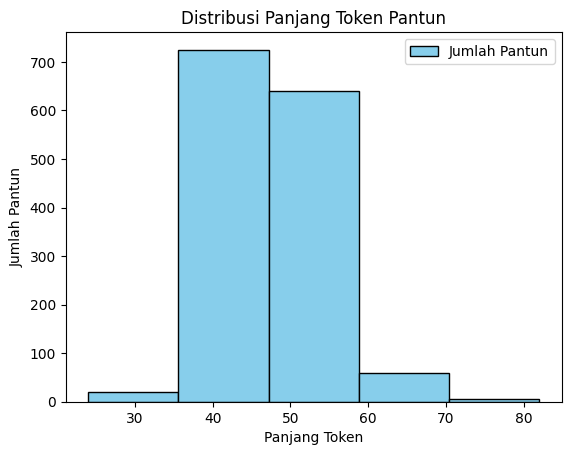

In [17]:
print(max(x), len(x))
# Plotting histogram
plt.hist(x, bins=5, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Token Pantun')
plt.xlabel('Panjang Token')
plt.ylabel('Jumlah Pantun')
plt.legend(['Jumlah Pantun'])
plt.show()

In [18]:
dataset = PoemDataset(data, tokenizer, max_length=max_length)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 1305
Number of samples for validation = 145


In [19]:
train_dataset[0]

(tensor([50257,    47,   271,   559,   256,  1228,   321,    11,   279,   271,
           559,   894,  7246,  3467,    77,   449, 37089, 48358,   541,    84,
           279,   271,   559, 39898,    84,  3467,    77,   327,   600,    64,
           384,    73,  7246,  4628, 15065,   288,  2743,  6877,    72,  3467,
            77, 36810,   272,  4628, 15065,   288,  2743,   299,  1878,  2385,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [20]:
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

print(len(train_dataloader))
print(len(train_dataset))

164
1305


In [21]:
# Using AdamW optimizer with default parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

In [22]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [23]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(epochs):
    print(f'Beginning epoch {epoch_i+1} of {epochs}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Labels are shifted by 1 timestep
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask=b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Sampling every x steps
        if step != 0 and step % sample_every == 0:

            elapsed = format_time(time.time()-t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,
                top_k=50,
                max_length=200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print(f'Example ouput: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            print()

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time()-t0)
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask=b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_time = format_time(time.time() - t0)
    print(f'Validation loss: {avg_val_loss}. Validation Time: {val_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': val_time
        }
    )
    print("------------------------------")

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 2.3457858562469482. Time: 0:00:08
Example ouput:  bipartisan inuk terga \n Yanga seu nasa kita juga \n Taksolah teran sampasannya tinga \n Beri memitu kis sisida

Average Training Loss: 3.4747602765153096. Epoch time: 0:00:13

Validation loss: 2.0370107826433683. Validation Time: 0:00:00

------------------------------
Beginning epoch 2 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.9021978378295898. Time: 0:00:07
Example ouput:  increasingBah terbang ada salam \n Jika ingin jelih perang dua \n Kalau sebaih karena rasan \n Kalau tempat kaki ku rakin

Average Training Loss: 1.888168553753597. Epoch time: 0:00:12

Validation loss: 1.7597352768245496. Validation Time: 0:00:00

------------------------------
Beginning epoch 3 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.522915005683899. Time: 0:00:07
Example ouput: dayDari roti suka \n Siapa yang lupa bolu \n Burung kota senang pisuh \n Beribu jauhir sukum dosa

Average Training Loss: 1.6351161613696958. Epoch time: 0:00:12

Validation loss: 1.677218838741905. Validation Time: 0:00:00

------------------------------
Beginning epoch 4 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.4813448190689087. Time: 0:00:07
Example ouput:  HangGung di pagi membeli \n kata duku juga dengan untuk \n Kaki muda tidak ditang selesa \n bisa dengan tebu orangnya

Average Training Loss: 1.4735624586663596. Epoch time: 0:00:12

Validation loss: 1.6430464230085675. Validation Time: 0:00:00

------------------------------
Beginning epoch 5 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.2710505723953247. Time: 0:00:07
Example ouput:  foodsMencari sisai pecah rusa \n Kekerja ingat mengail senja \n Jangan pernah ragam setinggi \n Agar jaga alamkan resiko

Average Training Loss: 1.337240103541351. Epoch time: 0:00:12

Validation loss: 1.6396494790127403. Validation Time: 0:00:00

------------------------------
Beginning epoch 6 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.1262589693069458. Time: 0:00:07
Example ouput:  trailPergi ke pasar membeli kain \n Pulangnya beli bersihatnya menanam \n Jika ingin jadi juara \n Kelak-kita membantu sangka dan rupin

Average Training Loss: 1.2115037928267223. Epoch time: 0:00:12

Validation loss: 1.6070441885998374. Validation Time: 0:00:00

------------------------------
Beginning epoch 7 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.0234997272491455. Time: 0:00:07
Example ouput: intendMakan lotek wit pecah pedagang \n Banyak yang melak terata \n Berjalan suka membuka budi \n Jika anak yang kedua

Average Training Loss: 1.0768465196214072. Epoch time: 0:00:12

Validation loss: 1.6653451543105275. Validation Time: 0:00:00

------------------------------
Beginning epoch 8 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 1.0311236381530762. Time: 0:00:07
Example ouput:  surroundMinah ketawa terjerit-jerit \n Jika berupa membara belajar \n Bukan memang pada siapat \n Mendapat sejati tunaikan

Average Training Loss: 0.9451414688331324. Epoch time: 0:00:12

Validation loss: 1.7093939718447233. Validation Time: 0:00:00

------------------------------
Beginning epoch 9 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.7724964022636414. Time: 0:00:07
Example ouput:  reflexDuyuh karang menggurui \n Ke mana datang suka sering \n Kalau kita ingin berteman \n Banyak ilmu bersama tempatmu

Average Training Loss: 0.8143141952956595. Epoch time: 0:00:12

Validation loss: 1.7861983713350797. Validation Time: 0:00:00

------------------------------
Beginning epoch 10 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.7736054062843323. Time: 0:00:07
Example ouput:  displayTuan puteri belajar menari \n Tari tidur mayur keliru \n Sama teman yang baik membuatmu \n Apa yang akan menjadi pintar

Average Training Loss: 0.6877265570730697. Epoch time: 0:00:12

Validation loss: 1.8922564857884456. Validation Time: 0:00:00

------------------------------
Beginning epoch 11 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.5310438871383667. Time: 0:00:07
Example ouput:  pastorJangan patahkan karangka \n Jangan lupa berkunjang-kunang \n Rajin mengaji rajin \n Pasti naik kelas

Average Training Loss: 0.5640539281615397. Epoch time: 0:00:12

Validation loss: 2.0030981615970007. Validation Time: 0:00:00

------------------------------
Beginning epoch 12 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.476846843957901. Time: 0:00:07
Example ouput:  illicitAnak turun sepuluh segar \n Mati satu tinggal sembilan \n Bangun pagi sembahyang subuh \n Bangun ciptaan Tuhan

Average Training Loss: 0.46539778516786856. Epoch time: 0:00:12

Validation loss: 2.1050462346327934. Validation Time: 0:00:00

------------------------------
Beginning epoch 13 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.37616056203842163. Time: 0:00:07
Example ouput:  LiberationDari laut ada kuda \n Berbuih ada harapan di sekolah \n Hati yang mau menjadi cinta \n Dilempar hidup di dalam hati

Average Training Loss: 0.38648350373273943. Epoch time: 0:00:12

Validation loss: 2.212435716076901. Validation Time: 0:00:00

------------------------------
Beginning epoch 14 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.3353096544742584. Time: 0:00:07
Example ouput:  NamMakan kain dengan suaranya \n Kedermain batik dibuat jamu \n Meski kau bukan tentang gelar \n Semoga dalam hatiku

Average Training Loss: 0.3342961906114729. Epoch time: 0:00:12

Validation loss: 2.2900295508535287. Validation Time: 0:00:00

------------------------------
Beginning epoch 15 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.30080029368400574. Time: 0:00:07
Example ouput: IONJika kita makan petai \n jangan lupa makan kerupuk \n Jika kita ingin pandai \n Rajin-rajinlah membaca buku

Average Training Loss: 0.2769748556722955. Epoch time: 0:00:12

Validation loss: 2.369299807046589. Validation Time: 0:00:00

------------------------------
Beginning epoch 16 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.22379638254642487. Time: 0:00:07
Example ouput:  glimpseLebat daun bunga kecubung \n Berbau harum bunga cempaka \n Adat dijaga pusaka dijunjung \n Baru terpelihara adat pusaka

Average Training Loss: 0.2348012073737819. Epoch time: 0:00:12

Validation loss: 2.3957097781331917. Validation Time: 0:00:00

------------------------------
Beginning epoch 17 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.21617920696735382. Time: 0:00:07
Example ouput:  LaureAnak kancil berlayar \n Berlabuh kapal membeli tikat \n Jikalau engkau bukan sampah \n Agar kamu merasa bahagia

Average Training Loss: 0.21211890249354085. Epoch time: 0:00:12

Validation loss: 2.4505925743203414. Validation Time: 0:00:00

------------------------------
Beginning epoch 18 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.2139265537261963. Time: 0:00:07
Example ouput: ismBuah salak buah duku \n tidak bisa dibuat jamu \n Meski jarang kita bertemu \n cintaku tetap hanya untukmu

Average Training Loss: 0.1908191974024947. Epoch time: 0:00:12

Validation loss: 2.508207026280855. Validation Time: 0:00:00

------------------------------
Beginning epoch 19 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.19248338043689728. Time: 0:00:07
Example ouput: ounPara petani bekerja di sawah \n Di sawah menanam padi \n Hidup jangan untuk mencari musuh \n Mari kita menanam budi pekerti

Average Training Loss: 0.17985357071568325. Epoch time: 0:00:12

Validation loss: 2.524312213847512. Validation Time: 0:00:00

------------------------------
Beginning epoch 20 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.17449221014976501. Time: 0:00:07
Example ouput:  electionAir tidak hanya ada di gelas \n Di teko pun ada air selalu \n Pengajar bukan hanya di kelas \n Pengalaman pun juga gurumu

Average Training Loss: 0.17124196877930223. Epoch time: 0:00:12

Validation loss: 2.5552963269384286. Validation Time: 0:00:00

------------------------------
Beginning epoch 21 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.14317792654037476. Time: 0:00:07
Example ouput:  crazyPohonnya bulat berdaun rindang \n Asam dan hijau ketika muda \n Bentuknya ia sebuah penjualang \npun masak, kuninglah ia? (Jawabannya: Belimbing)

Average Training Loss: 0.15847723104241418. Epoch time: 0:00:12

Validation loss: 2.5729754598517167. Validation Time: 0:00:00

------------------------------
Beginning epoch 22 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.12771156430244446. Time: 0:00:07
Example ouput:  benchMendapat rusa belang di kaki \n Rusanya makan daun suji \n Hendaklah Kamu memiliki \n Segenap akhlak baik terpuji

Average Training Loss: 0.15524617668877289. Epoch time: 0:00:12

Validation loss: 2.580487928892437. Validation Time: 0:00:00

------------------------------
Beginning epoch 23 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.15363511443138123. Time: 0:00:07
Example ouput:  incorporatedSungguh bahagia hati tertawa \n menjadi dibawa palu \n Jika menjadi daun tuhan punya \n Moga terhapus segala dosa

Average Training Loss: 0.1511186916926285. Epoch time: 0:00:12

Validation loss: 2.594819552020023. Validation Time: 0:00:00

------------------------------
Beginning epoch 24 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.12675589323043823. Time: 0:00:07
Example ouput: PeterJanganlah kamu suka mengolok \n Bisa-bisa rugi akhirnya \n Ada daun tak punya pok \n Setiap bangunan memilikinya?

Average Training Loss: 0.14153489524998317. Epoch time: 0:00:12

Validation loss: 2.611608812683507. Validation Time: 0:00:00

------------------------------
Beginning epoch 25 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1522752195596695. Time: 0:00:07
Example ouput: uringDi pinggir pantai main ayunan \n Melambung tinggi tiada terasa \n Bila memanggil dengan senyuman \n Orang pun datang dengan tertawa

Average Training Loss: 0.14273718776317632. Epoch time: 0:00:12

Validation loss: 2.633807533665707. Validation Time: 0:00:00

------------------------------
Beginning epoch 26 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1255185455083847. Time: 0:00:07
Example ouput:  reproductiveMelihat awan beriring-iringan \n Kerlip bintang berseri-seri \n Malam hari ada rembulan \n Siang hari ada matahari

Average Training Loss: 0.1410544213907021. Epoch time: 0:00:12

Validation loss: 2.6525682399147437. Validation Time: 0:00:00

------------------------------
Beginning epoch 27 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1440693885087967. Time: 0:00:07
Example ouput:  zoneJoni main bersama Yusa \n Tapi lupa mengajak Firman \n Jangan pernah remehkan puasa \n Karena puasa termasuk rukun iman

Average Training Loss: 0.1407084135202373. Epoch time: 0:00:12

Validation loss: 2.6539143763090434. Validation Time: 0:00:00

------------------------------
Beginning epoch 28 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.11901348829269409. Time: 0:00:07
Example ouput:  commitsDi jalan-jalan sama bagus \n Dibakarhuha tolong jus \n Kalau adik ingin menjadi pintar \n Jangan tak inggalkan resiko

Average Training Loss: 0.13748958425187482. Epoch time: 0:00:12

Validation loss: 2.6488834619522095. Validation Time: 0:00:00

------------------------------
Beginning epoch 29 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.13875140249729156. Time: 0:00:07
Example ouput:  ironyHari Minggu belanja ke pasar \n Membeli sayuran dan juga beras \n Tiap hari rajinlah belajar \n Agar di masa depan jadi orang yang cerdas

Average Training Loss: 0.13154814001627085. Epoch time: 0:00:12

Validation loss: 2.6845933010703638. Validation Time: 0:00:00

------------------------------
Beginning epoch 30 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.15406231582164764. Time: 0:00:07
Example ouput:  SahPasang siang seperti petang \n Petani panen hati rusa \n Jangan sampai kita suka menuding \n Nanti ikan cubalah teka apa

Average Training Loss: 0.12583645982894956. Epoch time: 0:00:12

Validation loss: 2.6793932099091378. Validation Time: 0:00:00

------------------------------
Beginning epoch 31 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.11556185036897659. Time: 0:00:07
Example ouput:  BryanBuah duku buah delima \n Buah salak satu ikat \n Suka duka berbagi bersama \n Denganmu wahai sahabat

Average Training Loss: 0.12346744932597731. Epoch time: 0:00:12

Validation loss: 2.6920659353858545. Validation Time: 0:00:00

------------------------------
Beginning epoch 32 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.13967858254909515. Time: 0:00:07
Example ouput:  spiritsJalan-jalan ke pinggir empang  \n nemu sendok dipinggir empang \n hati siapa tak bimbang \n situ botak minta dikepang

Average Training Loss: 0.12085029405609864. Epoch time: 0:00:12

Validation loss: 2.718037812333358. Validation Time: 0:00:00

------------------------------
Beginning epoch 33 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.11863629519939423. Time: 0:00:07
Example ouput:  seesKera di hutan cekat melompat \n Si pemburu memasang jerat \n Siapa aja bermain \n Karena kuasa Tuhan yang mama

Average Training Loss: 0.1215176124852605. Epoch time: 0:00:12

Validation loss: 2.6955375608644987. Validation Time: 0:00:00

------------------------------
Beginning epoch 34 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.12575379014015198. Time: 0:00:07
Example ouput:  hungryPohon kurma sebesar paha \n Pohon kemiri tidak berduri \n Mari bersama kita berusaha \n Membangun seni negeri sendiri

Average Training Loss: 0.11754238160281646. Epoch time: 0:00:12

Validation loss: 2.7129576708141125. Validation Time: 0:00:00

------------------------------
Beginning epoch 35 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.10269439220428467. Time: 0:00:07
Example ouput:  PTJalan-jalan ke pemancingan \n Berangkatnya naik motor \n Jangan melupakan pendidikan \n Karena di situ ilmu pengetahuan bertambah

Average Training Loss: 0.11743286901676073. Epoch time: 0:00:12

Validation loss: 2.711263524858575. Validation Time: 0:00:00

------------------------------
Beginning epoch 36 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.12569428980350494. Time: 0:00:07
Example ouput: üSungguh segar air selasih \n Untuk diminum waktu dahaga \n Sayangi ibu yang penuh kasih \n Berletih-letih  menjaga kita

Average Training Loss: 0.11824295842429487. Epoch time: 0:00:12

Validation loss: 2.7508965479700187. Validation Time: 0:00:00

------------------------------
Beginning epoch 37 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.12329023331403732. Time: 0:00:07
Example ouput: ruceKe toko swalayan membeli minyak zaitun \n Tiba di swalayan banyak anak bermain \n Selalu lah menjaga sopan santun \n Agar dihargai oleh orang lain

Average Training Loss: 0.11677236723281988. Epoch time: 0:00:12

Validation loss: 2.747651928349545. Validation Time: 0:00:00

------------------------------
Beginning epoch 38 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1015658900141716. Time: 0:00:07
Example ouput:  derivativesMlaku-mlaku ning Malioboro \n Menawi sayah numpak becak luwih sekeca \n Sugeng riyadi kagem panjenengan sedaya \n Sagung kalepatan nyuwun diparingi pangapura

Average Training Loss: 0.11248383357575754. Epoch time: 0:00:12

Validation loss: 2.7695902460499813. Validation Time: 0:00:00

------------------------------
Beginning epoch 39 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.12118761241436005. Time: 0:00:07
Example ouput: Tubuhmu begitu lentik \n pasti kamu sering minum jamu \n Bagi oranglain mungkin kau tidak terlalu cantik \n tapi bagiku tidak ada yang secantik dirimu

Average Training Loss: 0.11178241538383611. Epoch time: 0:00:12

Validation loss: 2.7676301190727637. Validation Time: 0:00:00

------------------------------
Beginning epoch 40 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.10108162462711334. Time: 0:00:07
Example ouput:  rememberingGelas termasuk barang pecah belah belah belah \n Maka jika dipegang terasa keras \n Marilah semangat pergi ke sekolah \n Tuntut ilmu dengan rajin jangan malas

Average Training Loss: 0.11197800984288134. Epoch time: 0:00:12

Validation loss: 2.794276281407005. Validation Time: 0:00:00

------------------------------
Beginning epoch 41 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1119140014052391. Time: 0:00:07
Example ouput:  SourcesBuah itu jangan dipetik \n Susah payah saat ditanam \n Engkaulah gadis tercantik \n Kuimpikan siang dan malam

Average Training Loss: 0.11105582277040656. Epoch time: 0:00:12

Validation loss: 2.7797056436538696. Validation Time: 0:00:00

------------------------------
Beginning epoch 42 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09983499348163605. Time: 0:00:07
Example ouput: emsPantai penuh dengan karang \n Datang ombak karang menahan \n Purnama bulat bersinar terang \n Karena kuasa Tuhan yang Agung

Average Training Loss: 0.10745737342754515. Epoch time: 0:00:12

Validation loss: 2.8092515531339144. Validation Time: 0:00:00

------------------------------
Beginning epoch 43 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.14941814541816711. Time: 0:00:07
Example ouput: tzCuka tebal tampang bengis \n Raup negeri sampai habis \n Wahai kau para zionis \n Bersiaplah untuk menangis

Average Training Loss: 0.10736868698604224. Epoch time: 0:00:12

Validation loss: 2.829859677113985. Validation Time: 0:00:00

------------------------------
Beginning epoch 44 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.10580480098724365. Time: 0:00:07
Example ouput: maticJalan-jalan untuk membeli benang \n Barang yang dipilih harus kuat \n Kalau mau selalu menang \n Harus jadi yang terbaik dan semangat

Average Training Loss: 0.10580599971297311. Epoch time: 0:00:12

Validation loss: 2.8522492270720634. Validation Time: 0:00:00

------------------------------
Beginning epoch 45 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0987972691655159. Time: 0:00:07
Example ouput:  syndAnak angsa mati lemas \n Mati lemas di air masin \n Hilang bahasa karena emas \n Hilang budi karena miskin

Average Training Loss: 0.10265812736640616. Epoch time: 0:00:12

Validation loss: 2.8228287822321843. Validation Time: 0:00:00

------------------------------
Beginning epoch 46 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1120491698384285. Time: 0:00:07
Example ouput:  gamBila datang bubuhkan paraf \n Tuliskan nama di dalam buku \n Kalau sudah memberi maaf \n Jangan ungkit salah yang lalu

Average Training Loss: 0.10308018463050447. Epoch time: 0:00:12

Validation loss: 2.833265448871412. Validation Time: 0:00:00

------------------------------
Beginning epoch 47 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09217573702335358. Time: 0:00:07
Example ouput:  injuryBesi bagus parang panjang \n Jatuh ke sawah tanah tanah gembur \n Pantai indah memanjang \n Ombak datang mendebur

Average Training Loss: 0.10284076303970523. Epoch time: 0:00:12

Validation loss: 2.8336685770436336. Validation Time: 0:00:00

------------------------------
Beginning epoch 48 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.11148194223642349. Time: 0:00:07
Example ouput: azaIndahnya wisata alam Kamboja \n Gelap malam dihiasi lentera \n Hidup damai rukun bersahaja \n Tanpa perang lebih sejahtera

Average Training Loss: 0.1005594977972711. Epoch time: 0:00:12

Validation loss: 2.8080795250440898. Validation Time: 0:00:00

------------------------------
Beginning epoch 49 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.1051078662276268. Time: 0:00:07
Example ouput:  membranePergi ke kota naik angkutan \n Tidak lupa berkunjung ke balai kota \n Punya sisik tapi bukan ikan \n Punya mahkota tapi bukan raja

Average Training Loss: 0.100180530829764. Epoch time: 0:00:12

Validation loss: 2.827327013015747. Validation Time: 0:00:00

------------------------------
Beginning epoch 50 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.10736342519521713. Time: 0:00:07
Example ouput: ijingPergi ke pasar membeli arang \n Banyak orang begitu ramai \n Begitu buruk istilah perang \n Tetaplah rukun ciptakan damai

Average Training Loss: 0.09848833733760728. Epoch time: 0:00:12

Validation loss: 2.8619503535722433. Validation Time: 0:00:00

------------------------------
Beginning epoch 51 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.11631414294242859. Time: 0:00:07
Example ouput:  castPulang siang di hari rabu \n Langsung tidur didalam rumah \n Walau aku sering mengecewakanmu \n Kasih ibu tetap tercurah

Average Training Loss: 0.09706555656725313. Epoch time: 0:00:12

Validation loss: 2.892505175188968. Validation Time: 0:00:00

------------------------------
Beginning epoch 52 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09040139615535736. Time: 0:00:07
Example ouput:  purchBerakit-rakit ke hulu \n Berenang-renang ketepian \n Ayok berangkat ke penghulu \n Dari pada Cuma temenan

Average Training Loss: 0.0988456175276419. Epoch time: 0:00:12

Validation loss: 2.874212515981574. Validation Time: 0:00:00

------------------------------
Beginning epoch 53 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09856217354536057. Time: 0:00:07
Example ouput:  shouldersSungguh bahaya ular berbisa \n bila tergigit akan koma \n sungguh bahagia kurasa \n bila kita slalu bersama

Average Training Loss: 0.09661978215160894. Epoch time: 0:00:12

Validation loss: 2.8776655636335673. Validation Time: 0:00:00

------------------------------
Beginning epoch 54 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08814997971057892. Time: 0:00:07
Example ouput:  builtKemanapun kaki melangkah \n Aku selalu mengurai doa \n Kemanapun cinta merambah \n Aku selalu mengurai setia

Average Training Loss: 0.095674739060242. Epoch time: 0:00:12

Validation loss: 2.8736063994859395. Validation Time: 0:00:00

------------------------------
Beginning epoch 55 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09660349041223526. Time: 0:00:07
Example ouput:  openlyJalan-jalan ke kota Blitar \n Beli semangka di Surabaya \n Jikalau adik ingin pintar \n Banyak membaca itu kuncinya

Average Training Loss: 0.09835491443007457. Epoch time: 0:00:12

Validation loss: 2.9021117310774955. Validation Time: 0:00:00

------------------------------
Beginning epoch 56 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09085047245025635. Time: 0:00:07
Example ouput:  haltedDaun terap di atas dulang \n Anak udang mati di tuba \n Dalam kitab ada terlarang \n Yang haram jangan dicoba

Average Training Loss: 0.09585969917839621. Epoch time: 0:00:12

Validation loss: 2.908180098784597. Validation Time: 0:00:00

------------------------------
Beginning epoch 57 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09304280579090118. Time: 0:00:07
Example ouput:  NikBeli sayur beli buah \n Hendak dimakan tapi masih mentah \n Jangan malas jangan lelah \n Semangat belajar teruskanlah

Average Training Loss: 0.09596511230963033. Epoch time: 0:00:12

Validation loss: 2.8806355250509164. Validation Time: 0:00:00

------------------------------
Beginning epoch 58 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.10471667349338531. Time: 0:00:07
Example ouput:  tinBeribu-ribu pohon beringin \n Hanya satu si pohon randu \n Saat malam terasa dingin \n Hanya wajahmu yang aku rindu

Average Training Loss: 0.0936839376099226. Epoch time: 0:00:12

Validation loss: 2.900907698430513. Validation Time: 0:00:00

------------------------------
Beginning epoch 59 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0923372432589531. Time: 0:00:07
Example ouput:  clinicalPergi ke Monas naik delman \n Melihat ramai burung dara \n Baik-baiklah kita berteman \n Banyak teman banyak saudara

Average Training Loss: 0.09259299029846017. Epoch time: 0:00:12

Validation loss: 2.878992513606423. Validation Time: 0:00:00

------------------------------
Beginning epoch 60 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.10509978234767914. Time: 0:00:07
Example ouput: lectionsBuah mangga dipetik Ata \n Mangga mantap itu punya Pak Ari \n Ayo bersama jaga lingkungan kita \n Agar tetap aman dan asri

Average Training Loss: 0.09091752976542566. Epoch time: 0:00:12

Validation loss: 2.914941530478628. Validation Time: 0:00:00

------------------------------
Beginning epoch 61 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08577672392129898. Time: 0:00:07
Example ouput: elsPecah perang di Syiria \n Perompak masuk mengacau negeri \n Majulah terus sahabat setia \n Berjuang terus membela negeri

Average Training Loss: 0.09056556206650851. Epoch time: 0:00:12

Validation loss: 2.9213816429439343. Validation Time: 0:00:00

------------------------------
Beginning epoch 62 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0919131487607956. Time: 0:00:07
Example ouput: labSiang-siang minum es \n Minumnya sambil nonton upin ipin \n Kamu tau siapa itu orang sukses \n Sukses itu adalah orang-orang rajin

Average Training Loss: 0.08995549426209636. Epoch time: 0:00:12

Validation loss: 2.8871612297861198. Validation Time: 0:00:00

------------------------------
Beginning epoch 63 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09114620834589005. Time: 0:00:07
Example ouput:  tripleHidup sehat di usia belia \n Minum air putih banyak manfaatnya \n Dia akan ikut bahagia \n Jika kamu bersamanya

Average Training Loss: 0.09018180664719605. Epoch time: 0:00:12

Validation loss: 2.9087302935750863. Validation Time: 0:00:00

------------------------------
Beginning epoch 64 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08312791585922241. Time: 0:00:07
Example ouput: 220Meringis kala tak berusaha \n Kilat nampak di atas ombak \n Tangis duka anak tak berdosa \n Melihat ibu bapak mati tertembak

Average Training Loss: 0.08887060931543024. Epoch time: 0:00:12

Validation loss: 2.9078428996236703. Validation Time: 0:00:00

------------------------------
Beginning epoch 65 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08389275521039963. Time: 0:00:07
Example ouput:  SeeBerkumpul dengan keluarga untuk arisan \n Pelamun sibuk dengan khayalan \n Barang siapa bermalas-malasan \n Kelak hidup penuh dengan penyesalan

Average Training Loss: 0.08823695974197329. Epoch time: 0:00:12

Validation loss: 2.9069971348109997. Validation Time: 0:00:00

------------------------------
Beginning epoch 66 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08617477864027023. Time: 0:00:07
Example ouput: @@Pergi ke pasar mencari daun selasih \n Jangan lupa juga beli semangka tanpa biji \n Ayo lekas berkemas mandi yang bersih \n Baru setelah itu segera pergi mengaji

Average Training Loss: 0.08819782415904649. Epoch time: 0:00:12

Validation loss: 2.9126251183058085. Validation Time: 0:00:00

------------------------------
Beginning epoch 67 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09174913167953491. Time: 0:00:07
Example ouput:  hostBurung Glatik \n Lagi hinggap di batu       \n Kamu memang cantik \n Tapi kok badannya bau

Average Training Loss: 0.08789678176910412. Epoch time: 0:00:12

Validation loss: 2.9457892681422986. Validation Time: 0:00:00

------------------------------
Beginning epoch 68 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.09294664859771729. Time: 0:00:07
Example ouput: roleAda gadis perawan \n paling cantik di kampungnya \n Hormatilah ibumu kawan \n Ada surga di telapak kakinya

Average Training Loss: 0.08759869712336761. Epoch time: 0:00:12

Validation loss: 2.934581160545349. Validation Time: 0:00:00

------------------------------
Beginning epoch 69 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08259443938732147. Time: 0:00:07
Example ouput: iacPerompak masuk ke negri Syiria \n Negeri Iran diancam juga \n Bila waktu damai di dunia? \n Negeri barat berperang saja

Average Training Loss: 0.08730151331642778. Epoch time: 0:00:12

Validation loss: 2.925589768510116. Validation Time: 0:00:00

------------------------------
Beginning epoch 70 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08330858498811722. Time: 0:00:07
Example ouput:  LDMakan malam lauknya ikan \n Pasti habis sepiring nasi \n Jangan lupa tuk berpantun \n Jika bertamu ke rumah betawi

Average Training Loss: 0.0882695365878867. Epoch time: 0:00:12

Validation loss: 2.910244213907342. Validation Time: 0:00:00

------------------------------
Beginning epoch 71 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08153187483549118. Time: 0:00:07
Example ouput:  ListenBoleh masak gulai lemak \n Makan lepas solat zohor \n Kesan tarbiyah oleh ulamak \n Nama Shafie kekal masyhur

Average Training Loss: 0.08616739179848171. Epoch time: 0:00:12

Validation loss: 2.9211210639853227. Validation Time: 0:00:00

------------------------------
Beginning epoch 72 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08855216950178146. Time: 0:00:07
Example ouput:  dyKuningan identik dengan tape ketan \n Tape ketan yang dibuat dengan sepenuh hati \n Kalau kamu ingin jadi panutan \n Jadilah dulu guru yang baik hati

Average Training Loss: 0.08606597912929408. Epoch time: 0:00:12

Validation loss: 2.9157098657206486. Validation Time: 0:00:00

------------------------------
Beginning epoch 73 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0892341285943985. Time: 0:00:07
Example ouput:  DomesticLiburan di kota Surabaya \n Keluar dari pesawat \n Negara ini memiliki ribuan budaya \n Tanda-tanda budaya jelas

Average Training Loss: 0.08512838375641078. Epoch time: 0:00:12

Validation loss: 2.928134240602192. Validation Time: 0:00:00

------------------------------
Beginning epoch 74 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0875895619392395. Time: 0:00:07
Example ouput:  beneficiariesJika akan datang melamar \n Jangan banyak tulis dihapus \n Pabila siswa rajin belajar \n Sudah pasti akan lulus

Average Training Loss: 0.08425135419863027. Epoch time: 0:00:12

Validation loss: 2.9332797841021887. Validation Time: 0:00:00

------------------------------
Beginning epoch 75 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08427886664867401. Time: 0:00:07
Example ouput:  TitleHidup bahagia orang yang iman \n Hatinya tunduk pada Rabbul Izzati \n Kasih sayanglah kepada teman \n Banyak teman banyak rezeki

Average Training Loss: 0.08364100935982495. Epoch time: 0:00:12

Validation loss: 2.9377634148848686. Validation Time: 0:00:00

------------------------------
Beginning epoch 76 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0824207216501236. Time: 0:00:07
Example ouput:  μJalan-jalan ke Bekasi \n Beli odeng lima ribuan \n Jangan lupa makan-makanan bergizi \n Untuk menjaga kesehatan

Average Training Loss: 0.08351071496925704. Epoch time: 0:00:12

Validation loss: 2.9288505504005835. Validation Time: 0:00:00

------------------------------
Beginning epoch 77 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07949724048376083. Time: 0:00:07
Example ouput:  sellingKalau Kamu pergi ke dusun \n Jangan lupa membawa beras \n Belajarlah secara tekun \n Supaya Kamu naik kelas

Average Training Loss: 0.08269365504384041. Epoch time: 0:00:12

Validation loss: 2.9474756278489767. Validation Time: 0:00:00

------------------------------
Beginning epoch 78 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07835331559181213. Time: 0:00:07
Example ouput:  migrantBuah salak baru dipetik \n Buah dukuh buah delima \n Ada banyak wanita cantik \n Cuma kamu yang aku cinta

Average Training Loss: 0.08317486596543615. Epoch time: 0:00:12

Validation loss: 2.9457219650870874. Validation Time: 0:00:00

------------------------------
Beginning epoch 79 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08542226254940033. Time: 0:00:07
Example ouput: ivelyBuah manggis buah markisa \n Buah nanas buah pepaya \n Nak, menangislah di hadapan orang tua \n Semoga doa terkabul olehnya

Average Training Loss: 0.08292793091840861. Epoch time: 0:00:12

Validation loss: 2.953709263550608. Validation Time: 0:00:00

------------------------------
Beginning epoch 80 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08991281688213348. Time: 0:00:07
Example ouput:  orderRujak kedondong rasanya pedas \n Belinya dari kota Jakarta \n Indahnya pemandangan Gunung Tampomas \n Hendaklah kita mentafakurinya

Average Training Loss: 0.08190053724115942. Epoch time: 0:00:12

Validation loss: 2.927103594729775. Validation Time: 0:00:00

------------------------------
Beginning epoch 81 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08339499682188034. Time: 0:00:07
Example ouput:  VPNKalau harimau sedang mengaum \n Bunyinya sangat berirama \n Kalau ada ulangan umum \n Marilah kita belajar bersama

Average Training Loss: 0.08194586811814367. Epoch time: 0:00:12

Validation loss: 2.9559006753720736. Validation Time: 0:00:00

------------------------------
Beginning epoch 82 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0769016221165657. Time: 0:00:07
Example ouput:  explanationLihat Messi mencetak gol \n tiba-tiba datang seorang tamu \n Aku ingin menjadi borgol \n supaya dapat memborgol cintamu

Average Training Loss: 0.08124958619293643. Epoch time: 0:00:12

Validation loss: 2.9623520374298096. Validation Time: 0:00:00

------------------------------
Beginning epoch 83 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08840356767177582. Time: 0:00:07
Example ouput:  BachKancil melompat katak heran \n Katak lompat pelan-pelan \n Sebentar lagi kita liburan \n Ingin aku jalan-jalan

Average Training Loss: 0.08108050358004687. Epoch time: 0:00:12

Validation loss: 2.9781902401070846. Validation Time: 0:00:00

------------------------------
Beginning epoch 84 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08259114623069763. Time: 0:00:07
Example ouput:  folderSungguh indah pohon di musim semi \n Daunnya indah banyak dipetiki \n Banyak - banyaklah bersilaturahmi \n Karena silaturahmi penyambung rezeki

Average Training Loss: 0.08053324230742163. Epoch time: 0:00:12

Validation loss: 2.984356108464693. Validation Time: 0:00:00

------------------------------
Beginning epoch 85 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08322303742170334. Time: 0:00:07
Example ouput:  buildingLangit membentang berwarna biru \n Langit dan laut tak akan bertemu \n Hormati olehmu seorang guru \n Mereka jadi sumber segala ilmu

Average Training Loss: 0.08053738183182914. Epoch time: 0:00:12

Validation loss: 2.978289986911573. Validation Time: 0:00:00

------------------------------
Beginning epoch 86 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07868677377700806. Time: 0:00:07
Example ouput:  BabylonWaktu petang masak ketan \n Sungguh lezat bersama rendang \n Rindu pulang kampung halaman \n Menikmati kebun dan ladang

Average Training Loss: 0.07993698456301922. Epoch time: 0:00:12

Validation loss: 2.977021160878633. Validation Time: 0:00:00

------------------------------
Beginning epoch 87 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07762998342514038. Time: 0:00:07
Example ouput: perialBebaskanlah semua pikiran \n Pejamkan mata rebahkan badan \n Jangan bilang setia kawan \n Kalau egois masih diemban

Average Training Loss: 0.08001804969659666. Epoch time: 0:00:12

Validation loss: 2.9621624632885584. Validation Time: 0:00:00

------------------------------
Beginning epoch 88 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08232907205820084. Time: 0:00:07
Example ouput:  rentsAda burung cendrawasih \n makan duku sampe  modar \n percayalah kasih \n kasih sayangku takkan pernah pudar

Average Training Loss: 0.07924634649804453. Epoch time: 0:00:12

Validation loss: 2.965747268576371. Validation Time: 0:00:00

------------------------------
Beginning epoch 89 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.0895349457859993. Time: 0:00:07
Example ouput:  RegBerakit-rakit ke hulu \n Berenang-renang ketepian \n Ayok berangkat ke penghulu \n Dari pada Cuma temenan

Average Training Loss: 0.07892447950818189. Epoch time: 0:00:12

Validation loss: 2.973460831140217. Validation Time: 0:00:00

------------------------------
Beginning epoch 90 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.08212590217590332. Time: 0:00:07
Example ouput: olasDulang bukan sembarang dulang \n Dulang besar sebesar rantang \n Bolang bukan sembarang bolang \n Bolang pemberani menyerang pantang

Average Training Loss: 0.07848633698573927. Epoch time: 0:00:12

Validation loss: 2.9773130416870117. Validation Time: 0:00:00

------------------------------
Beginning epoch 91 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07976102083921432. Time: 0:00:07
Example ouput:  responsesMakan buah jeruk rasanya asam \n Sama rasa dengan buah mangga \n Ayo kawan mari lestarikan alam \n Agar bumi selalu terjaga

Average Training Loss: 0.07823320882531201. Epoch time: 0:00:12

Validation loss: 2.9780117963489734. Validation Time: 0:00:00

------------------------------
Beginning epoch 92 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07751338928937912. Time: 0:00:07
Example ouput:  attendanceJangan patahkan atap mengkuang \n Atap patah kumbangpun lalu \n Jangan patahkan cakap orang \n Cakap patah orangnya malu

Average Training Loss: 0.0781632992552548. Epoch time: 0:00:12

Validation loss: 2.9753637941260087. Validation Time: 0:00:00

------------------------------
Beginning epoch 93 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07625739276409149. Time: 0:00:07
Example ouput:  rigidBerenang menuju samudera \n Indah nan permai negeri tercinta \n Perang membuat rakyat sengsara \n Dengan damai rakyat sentosa

Average Training Loss: 0.07729426526078363. Epoch time: 0:00:12

Validation loss: 2.98862413983596. Validation Time: 0:00:00

------------------------------
Beginning epoch 94 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07686901837587357. Time: 0:00:07
Example ouput: groDari empat hingga lima \n Hilang semua hingga punah \n Budi baik dikenang lama \n Walau jasad terkubur tanah

Average Training Loss: 0.07772755432056218. Epoch time: 0:00:12

Validation loss: 2.9802732404909635. Validation Time: 0:00:00

------------------------------
Beginning epoch 95 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07688962668180466. Time: 0:00:07
Example ouput:  GreSungguhlah besar taman Seri Mahkota \n Tempat bermain bidadari Lela Utama \n Sungguhlah benar bagi orang yang takwa \n Ada tempat yang aman dan bahagia

Average Training Loss: 0.07725742554700957. Epoch time: 0:00:12

Validation loss: 2.989256821180645. Validation Time: 0:00:00

------------------------------
Beginning epoch 96 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07505888491868973. Time: 0:00:07
Example ouput: uraPecah perang di Syiria \n Perompak masuk mengacau negeri \n Majulah Syiria mengamankan negara \n Berjuang terus membela negeri

Average Training Loss: 0.07671355615120108. Epoch time: 0:00:12

Validation loss: 2.995420242610731. Validation Time: 0:00:00

------------------------------
Beginning epoch 97 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07702354341745377. Time: 0:00:07
Example ouput:  2020Beli buku warnanya merah \n Kena hujan bukunya basah \n Berusahalah jangan menyerah \n Hidup ini memanglah susah

Average Training Loss: 0.07619564771288778. Epoch time: 0:00:12

Validation loss: 2.997533158252114. Validation Time: 0:00:00

------------------------------
Beginning epoch 98 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07327227294445038. Time: 0:00:07
Example ouput:  chargingMinum air dari labu \n Boleh dibawa bila berjalan \n Bimbingan awal dari ibu \n Serta kasih yang berkekalan

Average Training Loss: 0.0760297923825863. Epoch time: 0:00:12

Validation loss: 2.9990365567960238. Validation Time: 0:00:00

------------------------------
Beginning epoch 99 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07433507591485977. Time: 0:00:07
Example ouput:  SarJalan-jalan lewat kuburan \n Dekat jembatan ada tukang bakso \n Para siswa suka tawuran \n Akibatnya nanggung resiko

Average Training Loss: 0.07561631141821058. Epoch time: 0:00:12

Validation loss: 3.0001218193455745. Validation Time: 0:00:00

------------------------------
Beginning epoch 100 of 100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 164. Loss: 0.07094091176986694. Time: 0:00:07
Example ouput:  JasMeski hanya sebuah jambu \n tetap bisa dibuat jamu \n Meski jarang kita bertemu \n cintaku tetap hanya untukmu

Average Training Loss: 0.07520350604885961. Epoch time: 0:00:12

Validation loss: 3.001683184975072. Validation Time: 0:00:00

------------------------------
Total training took 0:20:15


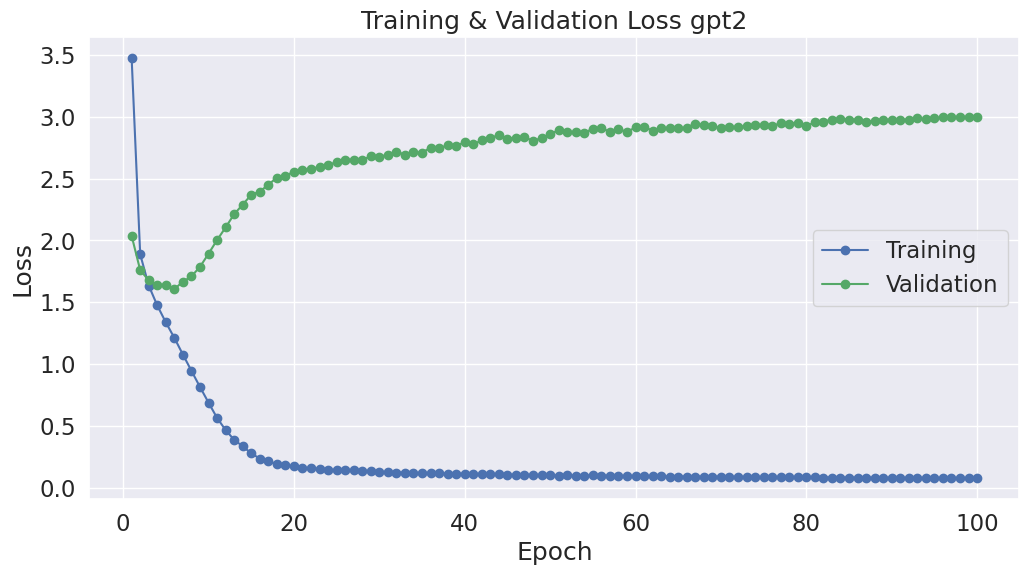

In [24]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title(f"Training & Validation Loss {model_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [25]:
model.eval()

prompt = "<|startoftext|>"
# prompt = ""

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Pagi-pagi tanam rambutan \n Pilih bibitnya yang unggul \n Yuk stop kebakaran hutan \n Agar hutan tidak menggundul


1: Jalan-jalan ke Ciamis \n Ada gedung parkirnya gratis \n Aku cinta sama si kumis \n orangnya ganteng lagi romantis


2: Jalan-jalan ke puncak gunung \n Jangan lupa bawa kentongan \n Sungguh indah kicaunya burung \n Melihat mereka hatiku senang




In [26]:
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.json',
 '/kaggle/working/merges.txt',
 '/kaggle/working/added_tokens.json')

In [27]:
# Save generated poems
sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=25
                                )

with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
    for i, sample_output in enumerate(sample_outputs):
        outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [28]:
def lexical_richness(text):
    tokens = nltk.word_tokenize(text.lower())
    unique_tokens = set(tokens)
    return (len(unique_tokens) / len(tokens)) * 100

def calculate_richness_score(pantun_list):
    richness_scores = [lexical_richness(pantun) for pantun in pantun_list]
    return sum(richness_scores) / len(richness_scores)

def calculate_structure_accuracy(pantun_list):
    correct_structure_count = 0
    total_pantun_count = len(pantun_list)
    for pantun in pantun_list:
        # Check if the pantun has correct structure
        if len(pantun.split('\\n')) == 4:
            correct_structure_count += 1
    structure_accuracy = correct_structure_count / total_pantun_count*100
    return structure_accuracy

def rhyme_check(pantun):
    # Memisahkan setiap baris pantun
    lines = pantun.split("\\n")
    
    # Mengambil kata terakhir dari setiap baris (jika ada)
    last_words = [line.split()[-1].lower() if line.strip() else "" for line in lines]
    
    # Mendefinisikan fungsi untuk mendapatkan vokal terakhir dari setiap kata
    def get_last_vowel(word):
        vowels = "aiueo"
        for char in reversed(word):
            if char.lower() in vowels:
                return char.lower()
        return None
    
    # Mendapatkan vokal terakhir dari setiap kata
    last_vowels = [get_last_vowel(word) for word in last_words]
    
    # Memeriksa kecocokan rima
    if len(last_vowels) == 4 and last_vowels[0] == last_vowels[2] and last_vowels[1] == last_vowels[3]:
        return 1
    else:
        return 0
    
def calculate_rhyme_correctness(pantuns):
    total_pantuns = len(pantuns)
    total_correct = 0
    
    for pantun in pantuns:
        if rhyme_check(pantun):
            total_correct += 1
    
    rhyme_correctness = (total_correct / total_pantuns) * 100
    return rhyme_correctness

In [29]:
# Membaca teks dari file
file_path = "/kaggle/working/generated_poems.txt"  # Ubah sesuai dengan path file Anda
with open(file_path, "r") as file:
    pantun_text = file.read()

# Memisahkan teks menjadi list tanpa karakter "\n"
pantun_list = pantun_text.split("\n")
pantun_list = [pantun for pantun in pantun_list if pantun.strip()]
# pantun_list = ["".join(pantun.split("\n")) for pantun in pantun_list]
# Menampilkan pantun dalam bentuk list
print(pantun_list)

['Beli sayur beli buah \\n Hendak dimakan tapi masih mentah \\n Jangan malas jangan lelah \\n Semangat belajar teruskanlah', 'Hendaklah tunggu kapal berlabuh \\n Berlabuh kapal membawa salak \\n Belajarlah kamu bersungguh sungguh \\n Agar bahagia hidupmu kelak', 'Kepala bunga lebat \\n Aroma manis bunga cempaka \\n Pusaka menjaga adat \\n Warisan baru dipertahankan', 'Beli bola jumlahnya lima \\n Aneka rupa warna-warnanya \\n Ilmu agama adalah utamanya \\n Bekal akhirat dan juga dunia', 'Tugal padi jangan bertangguh \\n Kunyit di kebun siapa penggalinya \\n Jika tuan cerdik sungguh \\n Langit tergantung di mana talinya', 'Berjalan bersama kawan \\n Sungguh lebar ini senyuman \\n Didik hati untuk dermawan \\n Untuk mendapat kasih Tuhan', 'Kembang gula di perigi \\n untuk aku minum jamu \\n ke mana pun kamu pergi \\n Aku selalu rindu kamu', 'Hati-hati masuk ke jurang \\n Jurang dalam banyak ularnya \\n 1000 teman terasa kurang \\n Seorang musuh banyak rasanya', 'Buah kemumu segar rasanya

In [30]:
average_richness_score = calculate_richness_score(pantun_list)
print(f"Average Lexical Richness Score: {average_richness_score:.2f}%")

accuracy_score = calculate_structure_accuracy(pantun_list)
print(f"Structure Accuracy Score: {accuracy_score:.2f}%")

rhyme_correctness = calculate_rhyme_correctness(pantun_list)
print(f"Persentase Rhyme Correctness Score: {rhyme_correctness:.2f}%")

Average Lexical Richness Score: 84.60%
Structure Accuracy Score: 100.00%
Persentase Rhyme Correctness Score: 100.00%


In [31]:
# Hitung perplexity
perplexity_scores = []
for text in pantun_list:
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    perplexity = torch.exp(loss)
    perplexity_scores.append(perplexity.item())

print("Average Perplexity Scores:", np.mean(perplexity_scores))

Average Perplexity Scores: 1.3589663410186767
